In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from fastai import *
from fastai.vision import *
from ipyexperiments import *

In [3]:
data_path = Path('../data/whale/')

In [4]:
data_path.ls()

[PosixPath('../data/whale/train'),
 PosixPath('../data/whale/train.csv'),
 PosixPath('../data/whale/cropped_training'),
 PosixPath('../data/whale/sample_submission.csv'),
 PosixPath('../data/whale/test_csv_2.csv'),
 PosixPath('../data/whale/train_csv_2.csv'),
 PosixPath('../data/whale/submissions'),
 PosixPath('../data/whale/models'),
 PosixPath('../data/whale/cropped_test'),
 PosixPath('../data/whale/test')]

In [5]:
train_csv2 = pd.read_csv(data_path/'train_csv_2.csv')
test_csv2 = pd.read_csv(data_path/'test_csv_2.csv')

In [6]:
train_csv2.shape, test_csv2.shape

((25361, 4), (7960, 3))

In [7]:
train_csv2.head(2)

,Image,Id,sizes,keras_model_bbox
0,0000e88ab.jpg,w_f48451c,"[3, 700, 1050]","(233, 160, 852, 417)"
1,0001f9222.jpg,w_c3d896a,"[3, 325, 758]","(0, 79, 744, 239)"


In [8]:
train_csv2.dtypes

Image               object
Id                  object
sizes               object
keras_model_bbox    object
dtype: object

# Data Pre-analysis

### bbox check and preprocess

In [9]:
# string to tuple and list
train_csv2.keras_model_bbox = train_csv2.keras_model_bbox.apply(lambda x: eval(x))
test_csv2.keras_model_bbox = test_csv2.keras_model_bbox.apply(lambda x: eval(x))

train_csv2.sizes = train_csv2.sizes.apply(lambda x: eval(x))
test_csv2.sizes = test_csv2.sizes.apply(lambda x: eval(x))

In [10]:
# check bboxes and clip if necessary
def check_bboxes(df):
    """
    Validate the bboxes by comparing with image size
    """
    bad_idxs = []
    for idx, (szs, bbxes) in df[['sizes', 'keras_model_bbox']].iterrows():

        _,y,x = szs 
        x1,y1,x2,y2 = bbxes

        x1 = np.clip(x1,a_min=0, a_max=x)
        y1 = np.clip(y1,a_min=0, a_max=y)
        x2 = np.clip(x2,a_min=0, a_max=x)
        y2 = np.clip(y2,a_min=0, a_max=y)

        x1, y1, x2, y2

        if not x2 - x1 > 0: 
            bad_idxs.append(idx)
            continue
        if not y2 - y1 > 0:
            bad_idxs.append(idx)
            continue
    return bad_idxs

In [11]:
train_bad_idxs = check_bboxes(train_csv2)
test_bad_idxs = check_bboxes(test_csv2)

In [12]:
train_csv2.iloc[train_bad_idxs]

,Image,Id,sizes,keras_model_bbox


In [13]:
test_csv2.iloc[test_bad_idxs]

,Image,sizes,keras_model_bbox


In [14]:
# fix bounding boxes
train_csv2.loc[train_bad_idxs, 'keras_model_bbox'] = \
train_csv2.loc[train_bad_idxs, 'sizes'].apply(lambda x: [0,0,x[2],x[1]]).values

test_csv2.loc[test_bad_idxs, 'keras_model_bbox'] = \
test_csv2.loc[test_bad_idxs, 'sizes'].apply(lambda x: [0,0,x[2],x[1]]).values

In [15]:
# save fixed bounding boxes
# train_csv2.to_csv(data_path/'train_csv_2.csv', index=False)
# test_csv2.to_csv(data_path/'test_csv_2.csv', index=False)

In [16]:
len(train_csv2), len(test_csv2)

(25361, 7960)

### All new whales

Find number new whales in public test set

In [19]:
test_csv2.shape

(7960, 3)

In [33]:
sample_submission = pd.read_csv(data_path/'sample_submission.csv'); sample_submission.head(2)

,Image,Id
0,00028a005.jpg,new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
1,000dcf7d8.jpg,new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c


In [36]:
# !kaggle competitions submit -c humpback-whale-identification -f '../data/whale/sample_submission.csv' -m "{all-whales-submission}"

In [35]:
!kaggle competitions submissions -c humpback-whale-identification

fileName                                          date                 description                                                                 status    publicScore  privateScore  
------------------------------------------------  -------------------  --------------------------------------------------------------------------  --------  -----------  ------------  
sample_submission.csv                             2018-12-23 01:26:44  {all-whales-submission}                                                     complete  0.277        None          
mpiotte-standard-400.csv.gz                       2018-12-22 12:13:57  {mpiotte-standard-400}                                                      complete  0.688        None          
resnet_18-224x448-random_batch-stage2-20-20epoch  2018-12-22 01:24:36  ../data/whale/submissions/resnet_18-224x448-random_batch-stage2-20-20epoch  complete  0.476        None          
sample_submission.csv                             2018-12-20 06:10:12  {all

In [37]:
public_leaderboard_new_whale_ratio = 0.227

In [38]:
training_new_whale_ratio = np.round(sum(train_csv2['Id'] == 'new_whale') / len(train_csv2), 3)

In [39]:
print(f"public_leaderboard_new_whale_ratio: {public_leaderboard_new_whale_ratio}")
print(f"training_new_whale_ratio: {training_new_whale_ratio}")
print(f"public leaderboard num new whales: {int(public_leaderboard_new_whale_ratio*len(test_csv2))}")
print(f"training num new whales: {int(training_new_whale_ratio*len(train_csv2))}")

public_leaderboard_new_whale_ratio: 0.227
training_new_whale_ratio: 0.381
public leaderboard num new whales: 1806
training num new whales: 9662


In [41]:
len(test_csv2)*0.381

3032.76

In [21]:
len(test_csv2)*0.227

1806.92

### Data

**Keys**

w : whale label

In [17]:
train_csv2.head(3)

,Image,Id,sizes,keras_model_bbox
0,0000e88ab.jpg,w_f48451c,"[3, 700, 1050]","(233, 160, 852, 417)"
1,0001f9222.jpg,w_c3d896a,"[3, 325, 758]","(0, 79, 744, 239)"
2,00029d126.jpg,w_20df2c5,"[3, 497, 1050]","(25, 20, 1012, 462)"


In [18]:
# whale id image counts - number of whale ids with only single image
w_counts = train_csv2.groupby(['Id'])['Id'].count().sort_values(ascending=False)
print(f"number of whale ids with single image: {sum(w_counts == 1)}")
print(f"number of unique whale ids in training: {len(w_counts)}")

number of whale ids with single image: 2073
number of unique whale ids in training: 5005


In [19]:
w2counts = dict(w_counts)
counts2w = {w2counts[k]:k for k in w2counts}
w2fnames = dict(train_csv2.groupby(['Id'])['Image'].apply(lambda x: list(x)))

In [20]:
list(w2fnames.items())[-5:]

[('w_ff94900', ['5ac086036.jpg']),
 ('w_ffa542b', ['4f9e431aa.jpg', '8abea550e.jpg', 'cd3a073a2.jpg']),
 ('w_ffa6d42', ['9dd320bb3.jpg']),
 ('w_ffcf5fe', ['d3967e1df.jpg']),
 ('w_ffe8693', ['df4bbd82a.jpg'])]

In [21]:
# (y, x)
all_sizes = np.vstack([np.vstack(train_csv2['sizes'].values)[:,1:], np.vstack(test_csv2['sizes'].values)[:,1:]])

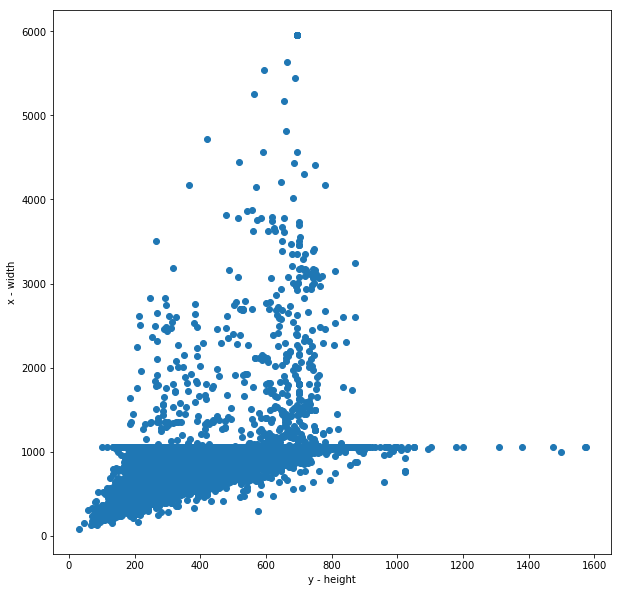

In [49]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(all_sizes[:,0], all_sizes[:,1])
ax.set_xlabel("y - height");
ax.set_ylabel("x - width");

In [50]:
aspect_ratios = all_sizes[:,0] / all_sizes[:,1]

(array([1.5990e+03, 9.8810e+03, 1.1233e+04, 1.0495e+04, 8.2000e+01, 1.6000e+01, 1.0000e+01, 4.0000e+00, 0.0000e+00,
        1.0000e+00]),
 array([0.075407, 0.26752 , 0.459634, 0.651747, 0.84386 , 1.035973, 1.228087, 1.4202  , 1.612313, 1.804427, 1.99654 ]),
 <a list of 10 Patch objects>)

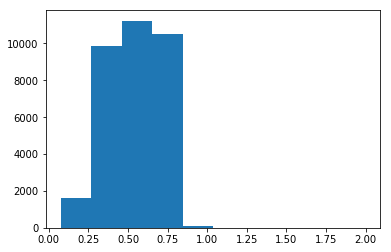

In [51]:
plt.hist(aspect_ratios)

In [52]:
print(f"x:y , height:width ratio {np.round(np.mean(aspect_ratios),2)}")

x:y , height:width ratio 0.53


# Data

### ImageBBox

In [20]:
from fastai.vision.transform import *

In [21]:
# convert bbox coords to have y first
def bb_xf2yf(bb):
    new_bb = [bb[:2][::-1] + bb[2:][::-1]]
    return new_bb
    
train_csv2['bboxes'] = train_csv2.keras_model_bbox.apply(lambda x: bb_xf2yf(x))
test_csv2['bboxes'] = test_csv2.keras_model_bbox.apply(lambda x: bb_xf2yf(x))

In [22]:
def get_bb_ex(i=0):
    img = open_image(data_path/'train'/train_csv2['Image'][i])
    bb = train_csv2['bboxes'][i]
    bbox = ImageBBox.create(*img.size, bboxes=bb)
    return img, bbox

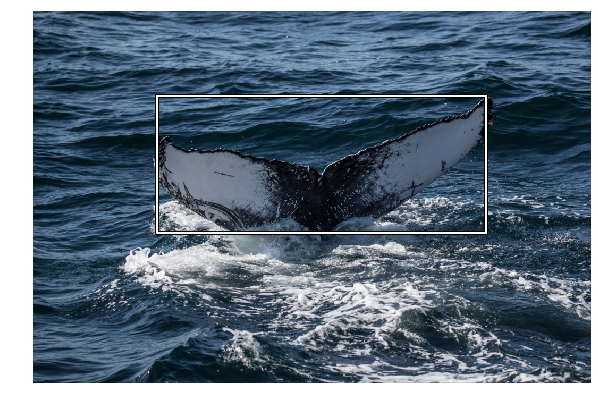

In [44]:
img, bbox = get_bb_ex(); img.show(y=bbox, figsize=(10,10))

In [23]:
def crop_img_with_bbox(img, bbox, margin=20):
    """crop an Image using bbox with margin"""
    bb = bbox.data[0]
    h,w = bbox.flow.size
    bb_np = (to_np(bb + 1)*([h/2, w/2, h/2, w/2]))
    bb_np = np.hstack([bb_np[:2] - margin, bb_np[2:] + margin]).astype(int)
    y1,x1,y2,x2 = (max(bb_np[0] - margin, 0),  max(bb_np[1] - margin, 0), 
                    min(bb_np[2] + margin, h), min(bb_np[3] + margin, w))
    return Image(img.data[:, y1:y2, x1:x2])

In [24]:
def resize_pad(img, size=224):
    """Resize to square keeping aspect ratio same"""
    new_sz = resize_to(img, size)
    img._flow = None
    img = img.resize((img.shape[0],*new_sz))
    
    lr, up = size - new_sz[0], size - new_sz[1]
    lr_div, lr_mod = divmod(lr, 2)
    up_div, up_mod = divmod(up, 2)
    return Image(F.pad(img.data, (up_div, up_div + up_mod, lr_div, lr_div + lr_mod)))

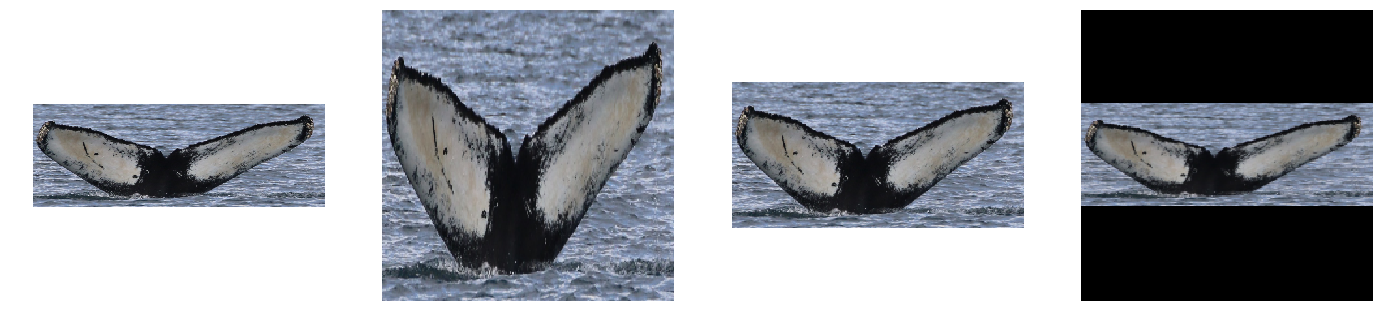

In [47]:
# plotting different crop and resizing techniques
img, bbox = get_bb_ex(i=100)
cropped_img = crop_img_with_bbox(img, bbox)
cropped_square_resized_img = crop_img_with_bbox(img, bbox).resize(size=224)
cropped_aspect_resized_img = crop_img_with_bbox(img, bbox).resize(size=(3, 224, 448))
cropped_pad_resized_img = resize_pad(crop_img_with_bbox(img, bbox), size=224)

_, axs = plt.subplots(1,4,figsize=(24,12))
for ax, img in zip(axs, [cropped_img, 
                         cropped_square_resized_img, 
                         cropped_aspect_resized_img, 
                         cropped_pad_resized_img]):
    img.show(ax=ax)

In [25]:
# resize transform without crop at the end
def my_resize(img):
    img = img.resize((3,(*size)))
    return img

resize_tfm = Transform(my_resize)

In [26]:
# resize transform without crop at the end
def my_resize(img):
    img = img.resize((3,224,448))
    return img
resize_tfm = Transform(my_resize)

# transforms
def get_whale_tfms(size=(224,448)):
    tfms = [[], []]
    tfms[0].append(flip_affine(p=0.5))
    max_lighting = 0.3; p_lighting=0.5
    tfms[0].append(brightness(change=(0.5*(1-max_lighting), 0.5*(1+max_lighting)), p=p_lighting))
    tfms[0].append(contrast(scale=(1-max_lighting, 1/(1-max_lighting)), p=p_lighting))
    tfms[0].append(rotate(degrees=10, p=0.5))
    max_warp = 0.3
    tfms[0].append(symmetric_warp(magnitude=(-max_warp,max_warp), p=0.3))
    tfms[0].append(Transform(lambda img: img.resize((3,(*size))))())
    tfms[1].append(Transform(lambda img: img.resize((3,(*size))))())
    return tfms

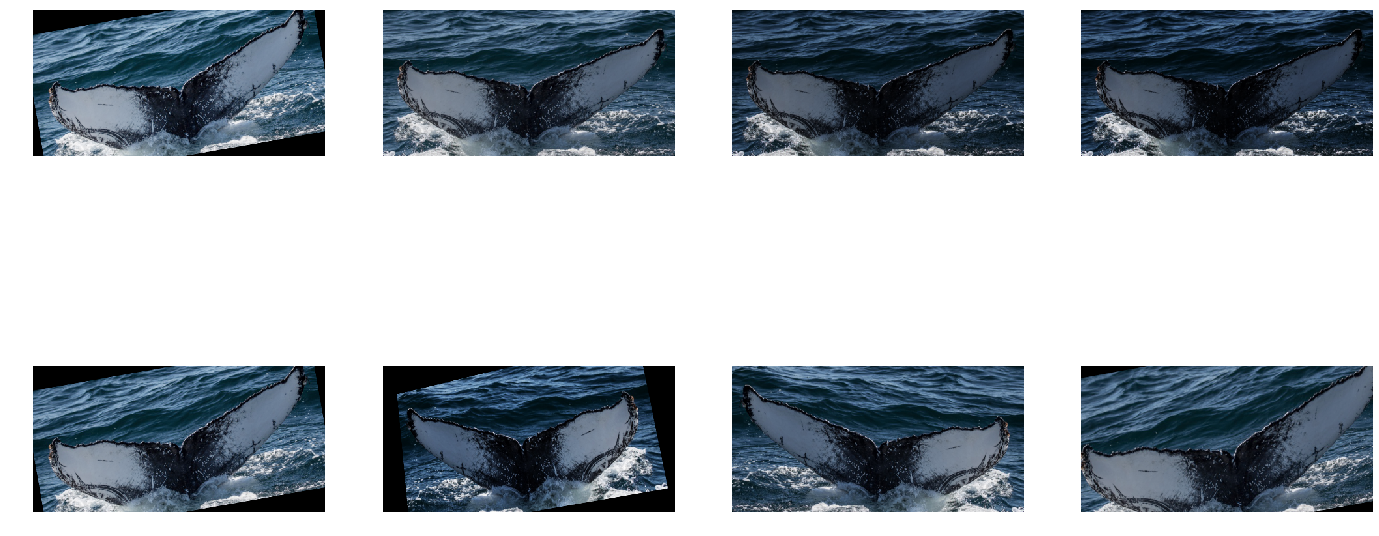

In [49]:
tfms = get_whale_tfms()
_, axs = plt.subplots(2,4,figsize=(24,12))
for ax in axs.flatten():
    img, bbox = get_bb_ex()
    img = crop_img_with_bbox(img, bbox, margin=20)
    img = img.apply_tfms(tfms[0], padding_mode='zeros')
    img.show(ax=ax)

### Save cropped images 

In [50]:
# data_path

# os.makedirs(data_path/'cropped_training', exist_ok=True)
# os.makedirs(data_path/'cropped_test', exist_ok=True)

# train_items = train_csv2[['Image', 'bboxes']].values
# test_items = test_csv2[['Image', 'bboxes']].values

# train_items[:2]

# def save_train_img(item):
#     img = open_image(data_path/'train'/item[0])
#     bb = item[1]
#     bbox = ImageBBox.create(*img.size, bboxes=bb)
#     img = crop_img_with_bbox(img, bbox, margin=20)
#     img.save(data_path/'cropped_training'/item[0])

# with ThreadPoolExecutor(max_workers=8) as ex:
#     ex.map(save_train_img, train_items)

# def save_test_img(item):
#     img = open_image(data_path/'test'/item[0])
#     bb = item[1]
#     bbox = ImageBBox.create(*img.size, bboxes=bb)
#     img = crop_img_with_bbox(img, bbox)
#     img.save(data_path/'cropped_test'/item[0])

# with ThreadPoolExecutor(max_workers=8) as ex:
#     ex.map(save_test_img, test_items)

# Databunch

In [27]:
# classes
idx2w = dict(enumerate(w2counts.keys()))
w2idx = {idx2w[k]:k for k in idx2w}
classes = list(w2counts.keys())

In [28]:
len(classes)

5005

In [29]:
# if only has 1 image put to train else split trn-val as max(1, len(x)*0.1)
np.random.seed(42)
train_fnames = []
valid_fnames = []
val_ratio = 0.1
for _, fnames in w2fnames.items():
    if len(fnames) == 1:
        train_fnames += fnames
    else:
        n = len(fnames)
        n_val = max(1, int(n*val_ratio)) 
        fnames = np.random.permutation(fnames)
        train_fnames += list(fnames[n_val:])
        valid_fnames += list(fnames[:n_val])

len(train_fnames), len(valid_fnames)

(21338, 4023)

In [30]:
train_df = train_csv2[train_csv2.Image.isin(train_fnames)].reset_index(drop=True)
valid_df = train_csv2[train_csv2.Image.isin(valid_fnames)].reset_index(drop=True)

In [31]:
print(f"unique classes in train : {train_df['Id'].nunique()}")
print(f"unique classes in valid: {valid_df['Id'].nunique()}")
print(f"unique classes with single image: {train_df['Id'].nunique() - valid_df['Id'].nunique()}")

unique classes in train : 5005
unique classes in valid: 2932
unique classes with single image: 2073


In [32]:
def get_data(train_df,
             valid_fnames,
             bs=64,
             size=(112,224),
             train_folder='cropped_training',
             test_folder='cropped_test',
             stats=imagenet_stats):
    """
    cosntruct from dataframe [Image, Id, ...] and validation fnames from Image col
    """
    itemlist = ImageItemList.from_df(train_df, data_path, folder=train_folder,
                                     cols=['Image'])
    itemlists = itemlist.split_by_valid_func(lambda item: True if
                                             Path(item).name in valid_fnames else False)
    labellists = itemlists.label_from_df()
    labellists = labellists.add_test(ImageItemList.from_folder(data_path/test_folder))
    data = (labellists.transform(get_whale_tfms(size=size), padding_mode='zeros')
        .databunch(bs=bs)
        .normalize(stats))
    return data

# Training

In [33]:
from utils import map5
from fastai.callbacks import EarlyStoppingCallback, TerminateOnNaNCallback

In [34]:
# validation baseline accuracy
np.mean(train_csv2[train_csv2['Image'].isin(valid_fnames)]['Id'] == 'new_whale')

0.2401193139448173

In [35]:
# define calllbacks
early_stopping = partial(EarlyStoppingCallback, monitor="map5", mode="max", patience=10)
terminate_nan = TerminateOnNaNCallback()

In [36]:
def auto_lr(recorder, skip_first=True):    
    """TODO: IMPROVE !"""
    losses = np.array([t.item() for t in learner.recorder.losses])
    lrs = learner.recorder.lrs
    if skip_first:
        idx = np.argmin(losses[1:][1:] - losses[1:][:-1])
        return lrs[1+1:][idx]
    else:
        idx = np.argmin(losses[1:] - losses[:-1])
        return lrs[1:][idx]

### Different data strategies

In [37]:
# DATA 1: all classes (including new whale) data
train_all_classes_df = train_csv2.copy()
train_all_classes_df.shape

(25361, 5)

In [38]:
# DATA 2: only known classes (excluding new whale) data
train_known_classes_df = train_all_classes_df[train_csv2['Id'] != "new_whale"].reset_index(drop=True)
train_known_classes_df.shape

(15697, 5)

In [39]:
# DATA 3: upsampled only known classes (excluding new whale) data
train_known_classes_df_trn = train_known_classes_df[train_known_classes_df['Image'].isin(train_fnames)]
train_known_classes_df_val = train_known_classes_df[train_known_classes_df['Image'].isin(valid_fnames)]

sample_to = 15
grouped = train_known_classes_df_trn.groupby('Id')
upsampled_train_known_classes_df_trn = grouped.apply(lambda x: x if len(x) > sample_to 
                                   else x.sample(sample_to, replace=True))
upsampled_train_known_classes_df = pd.concat([upsampled_train_known_classes_df_trn,
                                       train_known_classes_df_val]).reset_index(drop=True)
upsampled_train_known_classes_df.shape

(79105, 5)

In [40]:
# DATA 4: full data training - just disable validation

### Training - steps

In [41]:
all_classes_data_112 = get_data(train_all_classes_df,
                valid_fnames,
                bs=64,
                size=(112,112),
                train_folder='cropped_training',
                test_folder='cropped_test')

In [42]:
learner = create_cnn(data=all_classes_data_112,
                     arch=models.resnet50,
                     lin_ftrs=[2048],
                     metrics=[accuracy, map5],
                     loss_func=nn.CrossEntropyLoss(),
                     callback_fns=[early_stopping],
                     callbacks = [terminate_nan])

In [76]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


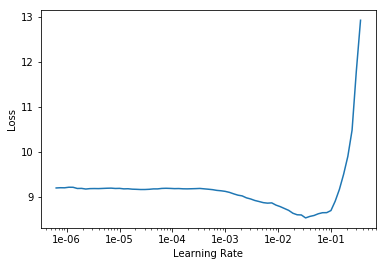

In [77]:
learner.recorder.plot()

#### 1) all classes size = 112x112

Initialize weights by training with all class images until validation doesn't improve anymore... size is `112x112`

In [55]:
learner.fit_one_cycle(100, slice(1e-2))

epoch,train_loss,valid_loss,accuracy,map5
1,5.641573,7.092168,0.236391,0.249706
2,5.186435,6.979351,0.242605,0.260374
3,4.857473,6.812575,0.241611,0.264666
4,4.619016,6.683303,0.251056,0.276083
5,4.432229,6.512535,0.253045,0.281403
6,4.149538,6.469533,0.256276,0.289742
7,3.990242,6.427906,0.265722,0.296814
8,3.794034,6.449197,0.265971,0.302697
9,3.530557,6.293358,0.268456,0.308377
10,3.298532,6.295266,0.275914,0.319256


Epoch 95: early stopping


In [60]:
learner.save("resnet50_all_112-stage1")

In [61]:
learner.unfreeze()

In [62]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


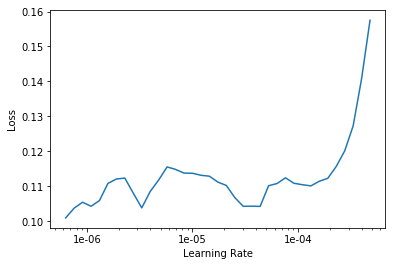

In [64]:
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(100, slice(5e-5))

epoch,train_loss,valid_loss,accuracy,map5
1,0.106166,7.032828,0.364405,0.451964
2,0.103533,7.337682,0.363659,0.451048
3,0.100547,7.074193,0.361422,0.449859
4,0.105762,7.242048,0.364902,0.452316
5,0.105195,7.144911,0.362665,0.451351
6,0.095413,7.143156,0.362665,0.450605
7,0.101473,7.160968,0.363410,0.452146
8,0.106664,7.082788,0.364156,0.452788
9,0.103009,7.109630,0.362665,0.451653
10,0.093586,7.023442,0.364405,0.452888


In [ ]:
learner.save("resnet50_all_112-stage2")

#### 2) all classes size = 224x224

Continue training with size `224x224`

In [50]:
learner.load("resnet50_all_112-stage2");

In [69]:
# increase size = (224,224)
all_classes_data_224 = get_data(train_all_classes_df,
                valid_fnames,
                bs=64,
                size=(224,224),
                train_folder='cropped_training',
                test_folder='cropped_test')

learner.data = all_classes_data_224

In [52]:
learner.freeze_to(-1)

In [53]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


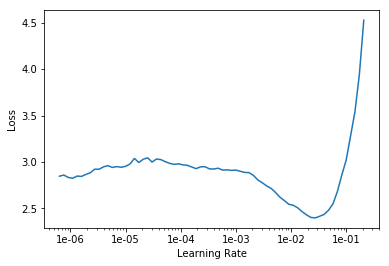

In [54]:
learner.recorder.plot()

In [55]:
learner.fit_one_cycle(100, slice(1e-2))

epoch,train_loss,valid_loss,accuracy,map5
1,1.937802,7.042240,0.312205,0.369496
2,1.318165,6.361568,0.331345,0.397175
3,0.900039,6.092044,0.346508,0.416605
4,0.675871,5.903263,0.356450,0.432828
5,0.474334,5.888388,0.361919,0.446827
6,0.401236,5.829393,0.366890,0.451831
7,0.348300,5.731112,0.377082,0.462039
8,0.338998,5.935069,0.378076,0.462988
9,0.348978,6.075350,0.380313,0.465668
10,0.384954,5.955908,0.378325,0.461625


Epoch 20: early stopping


In [57]:
learner.save("resnet50_all_224-stage1")

In [47]:
learner.load("resnet50_all_224-stage1");

In [48]:
learner.unfreeze()

In [49]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


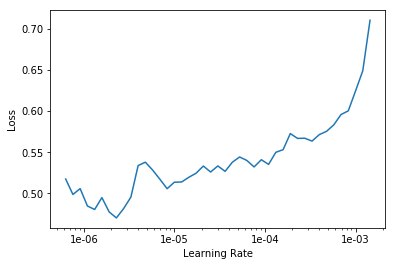

In [50]:
learner.recorder.plot()

In [51]:
learner.fit_one_cycle(100, slice(1e-6))

epoch,train_loss,valid_loss,accuracy,map5
1,0.561571,7.903740,0.369625,0.448194
2,0.532773,8.804130,0.371862,0.449159
3,0.527378,7.957930,0.371365,0.449039
4,0.546623,7.493686,0.372607,0.450443
5,0.540171,7.771009,0.370868,0.448326
6,0.538178,7.679183,0.370619,0.448434
7,0.522183,7.572796,0.369376,0.448554
8,0.546279,7.662034,0.372607,0.450348
9,0.511488,7.499506,0.371613,0.449681
10,0.548224,7.411763,0.373850,0.451007


Epoch 21: early stopping


In [52]:
learner.save("resnet50_all_224-stage2")

In [70]:
learner.load("resnet50_all_112-stage2");

In [71]:
learner.data.c

5005

In [74]:
learner.data.train_ds.y.c2i['new_whale']

0

In [76]:
train_all_c2i = learner.data.train_ds.y.c2i

#### 3) known classes size = 224x224

In [77]:
# increase size = (224,224)
all_classes_data_224 = get_data(train_known_classes_df,
                valid_fnames,
                bs=64,
                size=(224,224),
                train_folder='cropped_training',
                test_folder='cropped_test')

learner.data = all_classes_data_224

In [78]:
train_known_c2i = learner.data.train_ds.y.c2i

In [85]:
dict(list(train_all_c2i.items())[1:]).keys() == train_known_c2i.keys()

True

In [ ]:
# remove weight for  

In [86]:
learner.data.c

5004

In [94]:
# remove the connection in last layer for 'new whale class'
print(learner.model[-1][-1].weight.shape); learner.model[-1][-1].weight

torch.Size([5005, 2048])


Parameter containing:
tensor([[-0.2833, -0.7868, -0.5323,  ..., -0.7408, -0.4678, -0.8613],
        [-0.5941, -0.8202, -0.5502,  ..., -0.8944, -0.2956, -0.8822],
        [-0.3325, -0.9032, -0.3423,  ..., -0.8630, -0.3938, -0.9246],
        ...,
        [-0.7082, -0.5818, -0.4079,  ..., -0.7513, -0.3701, -0.9120],
        [-0.3018, -0.9424, -0.5126,  ..., -0.9395, -0.5067, -0.8553],
        [ 0.2035, -0.8106, -0.8706,  ..., -0.7605, -0.6276, -0.9497]],
       device='cuda:0', requires_grad=True)

In [95]:
print(learner.model[-1][-1].bias.shape); learner.model[-1][-1].bias

torch.Size([5005])


Parameter containing:
tensor([ 7.5351, -2.6072, -2.5955,  ..., -2.1269, -2.2485, -2.1290],
       device='cuda:0', requires_grad=True)

In [104]:
# init new final fc layer 5004 x 2048
new_fc = nn.Linear(2048, 5004)

In [105]:
learner.model[-1][-1].weight.data[1:].shape

torch.Size([5004, 2048])

In [108]:
new_fc.weight.data.copy_(learner.model[-1][-1].weight.data[1:])
new_fc.bias.data.copy_(learner.model[-1][-1].bias.data[1:])

tensor([-2.6072, -2.5955, -2.4788,  ..., -2.1269, -2.2485, -2.1290])

In [110]:
new_fc.weight

Parameter containing:
tensor([[-0.5941, -0.8202, -0.5502,  ..., -0.8944, -0.2956, -0.8822],
        [-0.3325, -0.9032, -0.3423,  ..., -0.8630, -0.3938, -0.9246],
        [-0.3697, -0.8550, -0.6058,  ..., -0.6338, -0.5945, -1.0269],
        ...,
        [-0.7082, -0.5818, -0.4079,  ..., -0.7513, -0.3701, -0.9120],
        [-0.3018, -0.9424, -0.5126,  ..., -0.9395, -0.5067, -0.8553],
        [ 0.2035, -0.8106, -0.8706,  ..., -0.7605, -0.6276, -0.9497]],
       requires_grad=True)

In [116]:
learner.model[-1][-1] = new_fc.cuda()

In [117]:
learner.model[-1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Lambda()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=4096, out_features=2048, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=2048, out_features=5004, bias=True)
)

In [118]:
learner.freeze_to(-1)

In [119]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


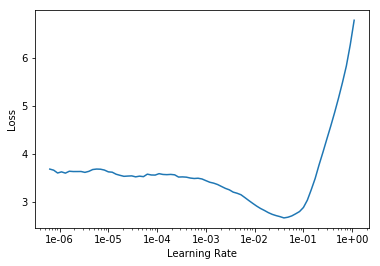

In [120]:
learner.recorder.plot()

In [121]:
learner.fit_one_cycle(100, slice(1e-2))

epoch,train_loss,valid_loss,accuracy,map5
1,2.559811,7.091749,0.176971,0.217299
2,1.797116,6.512123,0.208047,0.252350
3,1.235662,6.291802,0.242722,0.287117
4,0.828163,5.801921,0.264966,0.312867
5,0.587061,5.883407,0.288191,0.337711
6,0.395467,5.384709,0.306183,0.358216
7,0.280802,5.326268,0.315996,0.370647
8,0.228758,5.127252,0.323847,0.380416
9,0.200511,5.234824,0.336277,0.392013
10,0.189491,5.226244,0.332025,0.392394


Epoch 26: early stopping


In [122]:
learner.unfreeze()

In [123]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


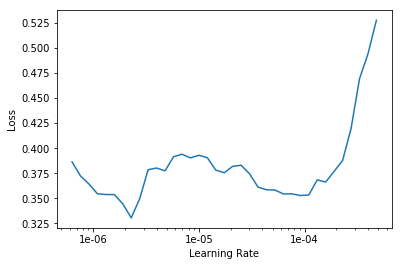

In [124]:
learner.recorder.plot()

In [125]:
learner.fit_one_cycle(100, slice(1e-6))

epoch,train_loss,valid_loss,accuracy,map5
1,0.387590,5.723235,0.350016,0.396603
2,0.371785,6.311320,0.350016,0.396800
3,0.371914,5.737375,0.348054,0.394608
4,0.375422,5.746296,0.351979,0.397710
5,0.409720,5.725977,0.344455,0.392035
6,0.393231,5.711661,0.352306,0.397961
7,0.371302,5.806613,0.345437,0.393627
8,0.364705,5.715385,0.348708,0.396620
9,0.386580,5.726696,0.351325,0.396811
10,0.391231,5.739836,0.349035,0.395807


Epoch 17: early stopping


In [126]:
learner.save("resnet50_known_224-stage2")

### Balanced batch training + Accumlute Gradients

Each class will have 1 sample per batch, since there is 5004 classes we can't fit every class in a batch. As a side effect it's assumed that weight updates at each batch without every class would be unstable and hard to learn. So we will update `on_epoch_end()` making sure each class is represented once at every epoch. This take longer but hopefully give better results.

In [46]:
from torch.utils.data import *

In [49]:
data = get_data(train_full_df, valid_fnames, bs=64, size=(112,224),
                train_folder='cropped_training', test_folder='cropped_test')

In [50]:
# map each label to training data indexes
from collections import defaultdict
labels = data.train_ds.y.items
idx2labels = dict(enumerate(labels))
label2idxs = defaultdict(list)

for idx,label in idx2labels.items():
    label2idxs[label].append(idx)

In [54]:
# to go over each class ideally should be roughly 
batch_size = 128
epoch_len = int(np.ceil(len(label2idxs) / batch_size))
epoch_len

40

In [55]:
class BalancedBatchSampler(Sampler):
    def __init__(self, batch_size, epoch_len, label2idxs):
        self.batch_size = batch_size
        self.epoch_len = epoch_len
        self.label2idxs = label2idxs
        
    def __iter__(self):
        """
        - Randomly select a subset of classes == bs at each batch
        - Then pick 1 images from each class
        - Repeat for epoch len
        """
        for i in range(self.epoch_len):
            batch_idxs = []
            batch_labels = np.random.choice(list(self.label2idxs.keys()),
                                            size=self.batch_size, replace=False)
            for label in batch_labels:
                label_idxs = label2idxs[label]
                batch_idxs.append(np.random.choice(label_idxs))  
            yield batch_idxs
            
    def __len__(self):
        return self.epoch_len

In [56]:
# monkey patch training dataloader to allow batch_sampler
batch_sampler = BalancedBatchSampler(batch_size, epoch_len, label2idxs)
data.train_dl = DeviceDataLoader(DataLoader(data.train_dl.dl.dataset, batch_sampler=batch_sampler),
                data.train_dl.device, data.train_dl.tfms,
                                data.train_dl.collate_fn)

In [57]:
# allow `on_epoch_end` update
class myOptimWrapper(OptimWrapper):
    def step(sellf):          pass
    def zero_grad(self):      pass
    def real_step(self):      super().step()
    def real_zero_grad(self): super().zero_grad()
        
@dataclass
class StepEpochEnd(Callback):
    learn:Learner
    def on_epoch_end(self, **kwargs):
        print("real step and zero grad")
        self.learn.opt.real_step()
        self.learn.opt.real_zero_grad()
        
original_create_opt_fn = Learner.create_opt
def my_create_opt(self, lr:Floats, wd:Floats=0.)->None:
    "Create optimizer with `lr` learning rate and `wd` weight decay."
    self.opt = myOptimWrapper.create(self.opt_func, lr, self.layer_groups,
                                     wd=wd, true_wd=self.true_wd, bn_wd=self.bn_wd)
Learner.create_opt = my_create_opt

In [60]:
learner = create_cnn(data=data, arch=models.resnet50, lin_ftrs=[2048],
                     metrics=[accuracy, map5],
                     loss_func=nn.CrossEntropyLoss(),
                     callback_fns=[early_stopping, partial(StepEpochEnd)])

In [67]:
learner.loss_func = nn.CrossEntropyLoss()

In [69]:
learner.fit_one_cycle(1000, max_lr=2e-2)

epoch,train_loss,valid_loss,accuracy,map5


RuntimeError: CUDA out of memory. Tried to allocate 196.00 MiB (GPU 0; 15.78 GiB total capacity; 5.87 GiB already allocated; 15.94 MiB free; 164.54 MiB cached)

In [191]:
learner.fit_one_cycle(1000, max_lr=2e-2)

epoch,train_loss,valid_loss,accuracy,map5
1,8.956395,8.658267,0.000183,0.000804
2,8.713559,8.552825,0.000914,0.001791
3,8.458506,8.514351,0.000914,0.002516
4,8.228082,8.460474,0.001279,0.003689
5,7.979134,8.400589,0.003107,0.005167
6,7.725102,8.333047,0.004021,0.006748
7,7.470407,8.288538,0.003656,0.007914
8,7.166095,8.223039,0.004387,0.008058
9,6.852352,8.192171,0.005483,0.010318
10,6.517516,8.160641,0.005849,0.011786


Epoch 71: early stopping


In [192]:
learner.save('resnet_18-224x448-balanced_batch-stage1')

### Submission


In [127]:
def get_preds(learner, ds_type=DatasetType.Test):
    learner.callbacks = [] # get_preds fail with TerminateOnNaNCallback
    preds = learner.get_preds(ds_type=ds_type)
    return preds

In [128]:
def add_new_whale(pred_probas, c2i, i2c, threshold):
    # add new whale predictions
    if "new_whale" not in c2i:
        """add new whale class if it's not present"""
        print("adding new whale to preds...")
        c2i["new_whale"] = len(c2i)
        i2c[len(i2c)] = "new_whale"   
        pred_probas = torch.cat([pred_probas, torch.ones((pred_probas.shape[0], 1))*threshold], 1)
    else: print("new whale already present in preds...")
    return pred_probas, i2c, c2i

In [129]:
def get_top5_idxs(learner, preds, ds_type=DatasetType.Test, threshold=0.9):
    """
    Get top 5 probas and target idxs
    """
    pred_probas, _ = preds
    c2i = learner.data.train_ds.y.c2i.copy()
    i2c = {c2i[c]:c for c in c2i}
    # add new whale 
    pred_probas, i2c, c2i = add_new_whale(pred_probas, c2i, i2c, threshold)
    # get top 5
    top5_probas = to_np(pred_probas.sort(dim=1, descending=True)[0][:,:5])
    top5_idxs = to_np(pred_probas.sort(dim=1, descending=True)[1][:, :5])
    return top5_probas, top5_idxs, i2c, c2i

In [130]:
def create_submission_df(learner, threshold=0.9):
    """create submission dataframe given a learner, learner.data should have test set added"""    
    
    preds = get_preds(learner)
    top5_probas, top5_idxs, i2c, c2i = get_top5_idxs(learner, preds, threshold=threshold)

    res = []
    for row in top5_idxs:
        res.append(" ".join([i2c[i.item()] for i in row]))
    
    n_new_whale = np.sum(top5_idxs == c2i["new_whale"]) / top5_idxs.shape[0]
    n_top1_new_whale = np.sum(top5_idxs[:, 0] == c2i["new_whale"]) / top5_idxs.shape[0]
    
    print(f"Number of new whale submission rows: {n_new_whale}")
    print(f"Number of top1 new whale submission rows: {n_top1_new_whale}")
    
    return pd.DataFrame({"Image":[o.name for o in learner.data.test_ds.items],
                         "Id":res})

### Tuning new whale threshold using full validation set

In [131]:
learner.load("resnet50_known_224-stage2");

In [132]:
len(learner.data.train_ds.y.c2i)

5004

In [133]:
# training data mapping
c2i_new = learner.data.train_ds.y.c2i

In [134]:
# original validation data -  tune threshold using with 'new_whale' included
data = get_data(train_all_classes_df,
                valid_fnames,
                bs=64,
                size=(224,224),
                train_folder='cropped_training',
                test_folder='cropped_test')
learner.data = data
c2i_val = learner.data.train_ds.y.c2i
i2c_val = {c2i_val[c]:c for c in c2i_val}
learner.data.train_ds.y.c2i = c2i_new

In [135]:
preds = get_preds(learner, DatasetType.Valid)

In [136]:
from utils import mapk 

for t in np.linspace(0.1,1,10):
    top5_probas, top5_idxs, i2c, c2i = get_top5_idxs(learner, preds, threshold=t)
    valid_ys = np.array([c2i[i2c_val[i]] for i in learner.data.valid_ds.y.items])
    valid_score = mapk(valid_ys.reshape(-1,1), top5_idxs, 5)
    print({"t":t, "map5":valid_score})

adding new whale to preds...
{'t': 0.1, 'map5': 0.4016281382053194}
adding new whale to preds...
{'t': 0.2, 'map5': 0.43196619438230177}
adding new whale to preds...
{'t': 0.30000000000000004, 'map5': 0.44949043002734285}
adding new whale to preds...
{'t': 0.4, 'map5': 0.46113182533764185}
adding new whale to preds...
{'t': 0.5, 'map5': 0.4658960974397216}
adding new whale to preds...
{'t': 0.6, 'map5': 0.4718617946805866}
adding new whale to preds...
{'t': 0.7000000000000001, 'map5': 0.47459607258264974}
adding new whale to preds...
{'t': 0.8, 'map5': 0.4752174993785732}
adding new whale to preds...
{'t': 0.9, 'map5': 0.4739746457867263}
adding new whale to preds...
{'t': 1.0, 'map5': 0.40437484464330103}


### Get test submission

In [137]:
model_name = "resnet50_known_224-stage2"

In [138]:
learner.load(model_name)
c2i = learner.data.train_ds.y.c2i
len(c2i), "new_whale" in c2i

(5004, False)

In [146]:
sub_df = create_submission_df(learner, threshold=0.3)

adding new whale to preds...
Number of new whale submission rows: 1.0
Number of top1 new whale submission rows: 0.29447236180904524


In [147]:
sub_df.to_csv(data_path/f"submissions/{model_name}", index=False)
subfilename = str(data_path/f"submissions/{model_name}")

In [148]:
!kaggle competitions submit -c humpback-whale-identification -f {subfilename} -m {model_name}

100%|█████████████████████████████████████████| 498k/498k [00:01<00:00, 301kB/s]
Successfully submitted to Humpback Whale Identification

In [149]:
!kaggle competitions submissions -c humpback-whale-identification

fileName                                           date                 description                                         status    publicScore  privateScore  
-------------------------------------------------  -------------------  --------------------------------------------------  --------  -----------  ------------  
resnet50_known_224-stage2                          2019-01-13 23:21:51  resnet50_known_224-stage2                           complete  0.442        None          
resnet50_known_224-stage2                          2019-01-13 23:14:45  resnet50_known_224-stage2                           complete  0.479        None          
mpiotte-standard-550.csv.gz                        2018-12-27 12:15:31  {mpiotte-standard-550}                              complete  0.726        None          
mpiotte-standard-590.csv.gz                        2018-12-27 11:45:02  {mpiotte-standard-590}                              complete  0.726        None          
mpiotte-standard-500.csv.gz 

### Few-shot learning